In [6]:
import umap
import plotly.graph_objs as go
from plotly.subplots import make_subplots


class UMAPProjection:
    def __init__(self, latent_space):
        self.latent_space = latent_space
        self.umap_reducer = None
        self.embedding = None
        self.fig = None
        self.hovertext = []
        self.hoverinfo = 'text'
        self.num_points = latent_space.shape[0]
        self.fig = make_subplots(rows=1, cols=1)

    def fit(self, num_points=10000):
        if num_points > self.num_points:
            num_points = self.num_points
        indices = np.random.choice(self.num_points, num_points, replace=False)
        self.umap_reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine')
        self.embedding = self.umap_reducer.fit_transform(self.latent_space[indices])
        for i in range(num_points):
            self.hovertext.append('Data point {}'.format(i))

    def plot(self):
        self.fig.add_trace(
            go.Scatter(x=self.embedding[:, 0], y=self.embedding[:, 1], mode='markers',
                       hovertext=self.hovertext, hoverinfo=self.hoverinfo),
            row=1, col=1
        )
        self.fig.update_layout(
            height=600, width=800,
            title='UMAP Projection of Latent Space',
            xaxis_title='UMAP 1', yaxis_title='UMAP 2'
        )
        self.fig.show()

    def on_click_callback(self, trace, points, state):
        if points.point_inds:
            selected_point = points.point_inds[0]
            inverse_embedding = self.umap_reducer.inverse_transform(self.embedding[selected_point].reshape(1, -1))
            print('Original latent space embedding:', inverse_embedding)

    def on_add_callback(self, trace, points, state):
        if points.point_inds:
            x, y = points.xs[0], points.ys[0]
            inverse_embedding = self.umap_reducer.inverse_transform(np.array([x, y]).reshape(1, -1))
            print('Estimated latent space embedding:', inverse_embedding)

    def enable_interactivity(self):
        self.fig.data[0].on_click(self.on_click_callback)
        # self.fig.data[0].on_add(self.on_add_callback)


In [7]:
import numpy as np

# Generate dummy latent space data
latent_space = np.random.rand(1000, 128)

# Create UMAPProjection instance and fit on latent space
umap_projection = UMAPProjection(latent_space)
umap_projection.fit()

# Plot the UMAP projection
umap_projection.plot()

# Enable interactivity
umap_projection.enable_interactivity()


In [9]:
import numpy as np
import umap
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist


class InteractiveAudioPlot:
    def __init__(self, audio_encoder, audio_effect, latent_space_size=128):
        self.audio_encoder = audio_encoder
        self.audio_effect = audio_effect
        self.latent_space_size = latent_space_size
        self.umap_embedder = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2)
        self.scaler = StandardScaler()
        self.umap_embedding = None
        self.audio_data = None
        self.fig, self.ax = plt.subplots()
        self.scatter = None
        self.cid = self.fig.canvas.mpl_connect('button_press_event', self.onclick)

    def fit_transform(self, audio_data):
        self.audio_data = audio_data
        latent_space = self.audio_encoder.predict(audio_data)
        self.scaler.fit(latent_space)
        scaled_latent_space = self.scaler.transform(latent_space)
        self.umap_embedding = self.umap_embedder.fit_transform(scaled_latent_space)
        self.scatter = self.ax.scatter(self.umap_embedding[:, 0], self.umap_embedding[:, 1])
        self.ax.set_title('Latent space projection')
        self.ax.set_xlabel('UMAP dimension 1')
        self.ax.set_ylabel('UMAP dimension 2')
        self.ax.set_aspect('equal')
        plt.show()

    def onclick(self, event):
        if event.inaxes == self.ax:
            if event.button == 1:  # left click
                distances = cdist(self.umap_embedding, np.array([[event.xdata, event.ydata]]))
                closest_point = np.argmin(distances)
                self.play_audio(closest_point)

            elif event.button == 3:  # right click
                self.add_point(event.xdata, event.ydata)

    def add_point(self, x, y):
        new_point = np.array([[x, y]])
        latent_space_point = self.scaler.inverse_transform(self.umap_embedder.inverse_transform(new_point))
        predicted_params = self.audio_effect.predict(latent_space_point)[0]
        self.umap_embedding = np.vstack((self.umap_embedding, new_point))
        self.scatter.set_offsets(self.umap_embedding)
        plt.draw()
        self.play_audio(-1, predicted_params)

    def play_audio(self, index, predicted_params=None):
        if index == -1:
            audio_data = self.audio_effect.predict(self.scaler.inverse_transform(self.umap_embedder.inverse_transform(np.array([[predicted_params]]))))[0]
            self.umap_embedding = np.vstack((self.umap_embedding, np.array([[np.nan, np.nan]])))
            self.scatter.set_offsets(self.umap_embedding)
            plt.draw()
        else:
            audio_data = self.audio_data[index]
        ipd.display(ipd.Audio(audio_data, rate=44100))


In [ ]:
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, CustomJS, HoverTool
from bokeh.plotting import figure
from bokeh.sampledata import iris
from bokeh.layouts import column
from bokeh.models.widgets import Audio

# define the generate_audio function that generates the audio file
def generate_audio(audio_file_path):
    # generate the audio file
    # ...
    # return the file path of the generated audio file
    return generated_audio_file_path

# load the audio file paths and coordinates data into a pandas dataframe
df = pd.read_csv('audio_data.csv')

# create the ColumnDataSource object from the dataframe
source = ColumnDataSource(df)

# create the scatterplot
plot = figure(x_axis_label='X-axis', y_axis_label='Y-axis')
plot.circle(x='x', y='y', source=source, size=10, color='blue')

# add hover tool to show the audio file name on mouse over
hover = HoverTool(tooltips=[('Audio File', '@audio_file')], mode='mouse')
plot.add_tools(hover)

# create the audio widget
audio = Audio(url='file_path', autoplay=False, loop=False)

# create the JavaScript callback to play the audio on scatterplot click
callback = CustomJS(args=dict(audio=audio, source=source), code="""
    const selected_index = source.selected.indices[0];
    const audio_file_path = source.data['file_path'][selected_index];
    // call the Python function to generate the audio file
    const xhr = new XMLHttpRequest();
    xhr.open('GET', 'http://localhost:8000/generate_audio?audio_file_path=' + audio_file_path, true);
    xhr.send();
    xhr.onreadystatechange = function() {
        if (xhr.readyState == 4 && xhr.status == 200) {
            const generated_audio_file_path = xhr.responseText;
            audio.url = generated_audio_file_path;
            audio.play();
        }
    };
""")

# add the callback to the scatterplot
plot.js_on_event('tap', callback)

# show the scatterplot and audio widget in a column layout
layout = column(plot, audio)
output_notebook()
show(layout)


In [7]:
%matplotlib widget

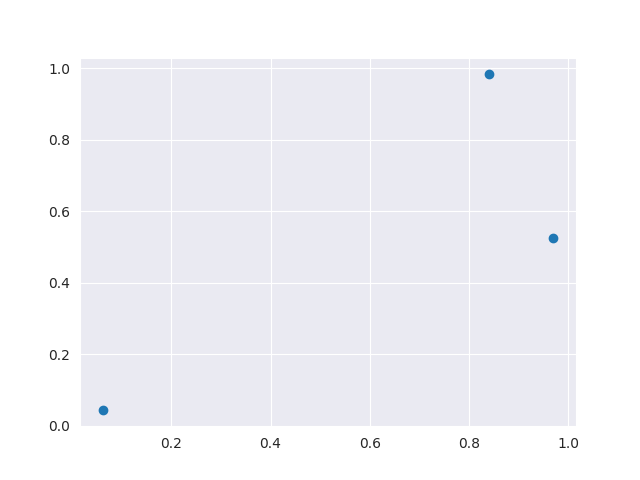

In [9]:
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import numpy as np
import librosa

# Assume we have a list of file names for the audio files
audio_files = ['audio1.wav', 'audio2.wav', 'audio3.wav']

def generate_audio(filename):
    audio, sr = librosa.load(filename)
    return audio

# Define a function to generate and play the audio for a given file
def play_audio(file_name):
    # Generate the audio using a hypothetical function called `generate_audio`
    audio_data = generate_audio(file_name)
    # Save the audio to disk
    np.savetxt(file_name, audio_data)
    # Play the audio using IPython.display.Audio
    display(Audio(audio_data, rate=44100))

# Generate some sample data for the scatterplot
x = np.random.rand(len(audio_files))
y = np.random.rand(len(audio_files))

# Create the scatterplot and add the click event handler
fig, ax = plt.subplots()
scatter = ax.scatter(x, y)

def on_click(event):
    print("HELLO!")
    # Check if the click event occurred on a scatter point
    if event.artist == scatter:
        # Get the index of the clicked point
        index = event.ind[0]
        # Get the corresponding file name
        file_name = audio_files[index]
        # Generate and play the audio
        play_audio(file_name)

# Connect the click event handler to the scatterplot
fig.canvas.mpl_connect('button_press_event', on_click)

# Show the scatterplot
plt.show()
